### 0 - Import packages  

In [1]:
! pip install lifelines scikit-survival

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sksurv.util import Surv
from sksurv.metrics import brier_score
from sksurv.ensemble import RandomSurvivalForest
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

### 1 - Cleaning data

For this first example, we will use the Metabric Dataset.

We got a sample of it on Kaggle: 

https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric?resource=download


In [3]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data

/tmp/ipykernel_21178/1434437314.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Exploring data, we have 31 variables and a lot of genetic information.
This genetic data, is obviously important and insightful, but we will first get rid of it in order to more easily get a grasp of what survival analyses and models are. 
We also get rid of some variables that we won't use for this example.

We also get rid of the lines with NaN.

In [4]:
data = data.loc[:, :"death_from_cancer"]
Variables_to_drop = [
    "patient_id",
    "cancer_type_detailed",
    "cellularity",
    "pam50_+_claudin-low_subtype",
    "cohort",
    "her2_status_measured_by_snp6",
    "tumor_other_histologic_subtype",
    "integrative_cluster",
    "oncotree_code",
    "3-gene_classifier_subtype",
    "overall_survival"
    ]
columns= list(data.columns)
for i in Variables_to_drop:
    if i in columns:
        data=data.drop(i,axis=1)

data.head(2)

,age_at_diagnosis,type_of_breast_surgery,cancer_type,chemotherapy,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,pr_status,radio_therapy,tumor_size,tumor_stage,death_from_cancer
0,75.65,MASTECTOMY,Breast Cancer,0,Positve,Positive,3.0,Negative,1,Post,Right,10.0,NaN,6.044,140.500000,Negative,1,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Cancer,0,Positve,Positive,3.0,Negative,1,Pre,Right,0.0,2.0,4.020,84.633333,Positive,1,10.0,1.0,Living


In [5]:
data = data.dropna(axis=0)
print( "sample size: ", len(data))
print("")
print("number of different obs")
for i in data.columns:
    print (i, len(data[i].unique()))

sample size:  1273

number of different obs
age_at_diagnosis 1111
type_of_breast_surgery 2
cancer_type 1
chemotherapy 2
er_status_measured_by_ihc 2
er_status 2
neoplasm_histologic_grade 3
her2_status 2
hormone_therapy 2
inferred_menopausal_state 2
primary_tumor_laterality 2
lymph_nodes_examined_positive 28
mutation_count 28
nottingham_prognostic_index 206
overall_survival_months 1169
pr_status 2
radio_therapy 2
tumor_size 66
tumor_stage 4
death_from_cancer 3


Separating variables from censor and survival data and transforming object variables into dummies

In [6]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months"]) 

X = pd.get_dummies(X, columns=[
    "cancer_type",
    "type_of_breast_surgery",
    "er_status_measured_by_ihc",
    "er_status",
    "her2_status",
    "inferred_menopausal_state",
    "primary_tumor_laterality",
    "pr_status"],
     drop_first=True)
X = X.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X.head()

,age_at_diagnosis,chemotherapy,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,radio_therapy,tumor_size,tumor_stage,type_of_breast_surgery_MASTECTOMY,er_status_measured_by_ihc_Positve,er_status_Positive,her2_status_Positive,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,pr_status_Positive
1,43.19,0,3.0,1,0.0,2.0,4.020,1,10.0,1.0,0,1,1,0,1,1,1
2,48.87,1,2.0,1,1.0,2.0,4.030,0,15.0,2.0,1,1,1,0,1,1,1
3,47.68,1,2.0,1,3.0,1.0,4.050,1,25.0,2.0,1,1,1,0,1,1,1
4,76.97,1,3.0,1,8.0,2.0,6.080,1,40.0,2.0,1,1,1,0,0,1,1
5,78.77,0,3.0,1,0.0,4.0,4.062,1,31.0,4.0,1,1,1,0,0,0,1


In [7]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == "Died of Disease").astype(int)
y=y.drop("death_from_cancer", axis=1)

y.head()

/tmp/ipykernel_21178/1886494465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == "Died of Disease").astype(int)


,overall_survival_months,Died_of_Desease
1,84.633333,0
2,163.700000,1
3,164.933333,0
4,41.366667,1
5,7.800000,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2 - Cox Model

In [20]:
Cox_train = X_train.join(y_train)
Cox_test = X_test.join(y_test)

In [21]:
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col="overall_survival_months", event_col="Died_of_Desease")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1018 total observations, 676 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'Died_of_Desease'
      baseline estimation = breslow
   number of observations = 1018
number of events observed = 342
   partial log-likelihood = -2127.79
         time fit was run = 2025-01-26 15:29:07 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
age_at_diagnosis                   0.02      1.02      0.01            0.00            0.03                1.00                1.03
chemotherapy                       0.17      1.19      0.19           -0.20            0.54                0.82                1.71
neoplasm_histologic_grade         -0.00      1.00      0.16           -0.32            0.32                0.73                1.38
hormone_therapy                   -0.21      0.81      0.15           -0.50            0.08                0.61                1.08
lymph_nodes_examined_positive      0.03      1.03      0.02            0.00            0.07                1.00                1.07
mutation_count                     0.01      1.02      0.01           -0.01            0.04                0.99                1.04
nottingham_prognostic_index        0.27      1.31      0.13            0.03            0.52                1.03                1.68
radio_therapy                     -0.20      0.82      0.14           -0.48            0.08                0.62                1.08
tumor_size                         0.01      1.01      0.00           -0.00            0.01                1.00                1.01
tumor_stage                        0.21      1.24      0.13           -0.03            0.46                0.97                1.59
type_of_breast_surgery_MASTECTOMY  0.05      1.05      0.14           -0.22            0.32                0.80                1.37
er_status_measured_by_ihc_Positve -0.03      0.97      0.27           -0.56            0.50                0.57                1.66
er_status_Positive                 0.00      1.00      0.25           -0.49            0.50                0.61                1.65
her2_status_Positive               0.53      1.69      0.15            0.23            0.82                1.26                2.27
inferred_menopausal_state_Pre      0.33      1.39      0.20           -0.06            0.72                0.94                2.06
primary_tumor_laterality_Right    -0.10      0.90      0.11           -0.32            0.11                0.73                1.12
pr_status_Positive                -0.08      0.93      0.13           -0.34            0.18                0.71                1.20

                                   cmp to     z      p  -log2(p)
covariate                                                       
age_at_diagnosis                     0.00  2.46   0.01      6.15
chemotherapy                         0.00  0.91   0.36      1.46
neoplasm_histologic_grade            0.00 -0.00   1.00      0.00
hormone_therapy                      0.00 -1.44   0.15      2.74
lymph_nodes_examined_positive        0.00  1.98   0.05      4.40
mutation_count                       0.00  1.13   0.26      1.96
nottingham_prognostic_index          0.00  2.18   0.03      5.09
radio_therapy                        0.00 -1.42   0.16      2.68
tumor_size                           0.00  1.64   0.10      3.32
tumor_stage                          0.00  1.69   0.09      3.45
type_of_breast_surgery_MASTECTOMY    0.00  0.35   0.73      0.46
er_status_measured_by_ihc_Positve    0.00 -0.11   0.92      0.13
er_status_Positive                   0.00  0.02   0.99      0.02
her2_status_Positive                 0.00  3.50 <0.005     11.08
inferred_menopausal_state_Pre        0.00  1.65   0.10      3.

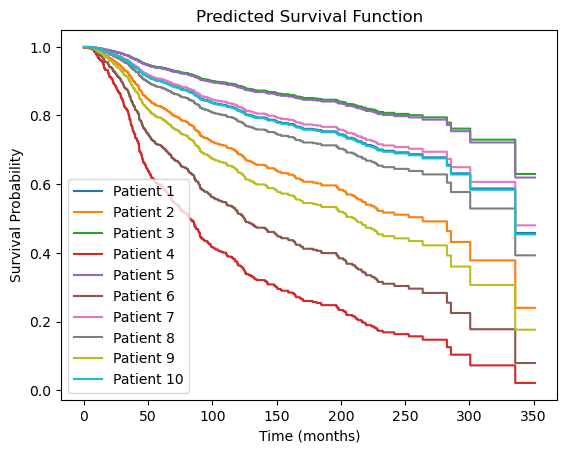

In [29]:
survival_func = cph.predict_survival_function(X_test)

for i in range(10):
    plt.step(survival_func.index, survival_func.iloc[:, i], where="post", label=f"Patient {i+1}")

plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Function")
plt.legend()
plt.show()

### 3 - RSF Model

In [9]:
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [10]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(random_state=42)

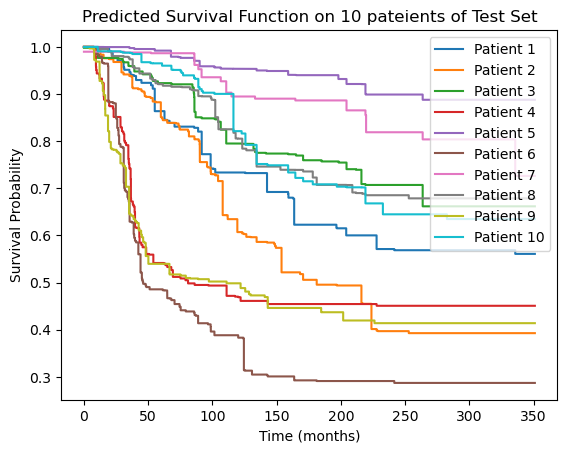

In [11]:
survival_probs = rsf.predict_survival_function(X_test)

for i, survival_func in enumerate(survival_probs[:10]):
    plt.step(survival_func.x, survival_func.y, where="post", label=f"Patient {i+1}")

plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Function on 10 pateients of Test Set")
plt.legend()
plt.show()

### 4 - Performances

In [40]:
preds = [fn(12) for fn in survival_probs]
brier = brier_score(y_train_RSF, y_test_RSF, preds, 12)

print(f"Brier Score du modèle RSF : {brier}")

Brier Score du modèle RSF : (array([12]), array([0.00840253]))
